In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models, transforms
import torchvision
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import os
import glob
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
from unet import UNet
from tqdm import tqdm

torch.manual_seed(1)
use_cuda = torch.cuda.is_available()
print("pytorch versino:", torch.__version__)
print("use cuda:", use_cuda)

pytorch versino: 0.4.0
use cuda: False


## Load Images

In [2]:

#base_dir = "/floyd/input/data"
base_dir = "../salt_data"
test_image_dir = os.path.join(base_dir, "test")
train_dir = os.path.join(base_dir, "train")
train_image_dir = os.path.join(train_dir, "images")
train_mask_dir = os.path.join(train_dir, "masks")

fname_train_images = glob.glob(os.path.join(train_image_dir, "*.png"))
fname_train_masks = glob.glob(os.path.join(train_mask_dir, "*.png"))
fname_test_images = glob.glob(os.path.join(test_image_dir, "*.png"))

train_ids = [os.path.split(fname)[1].replace(".png", "") for fname in fname_train_images]
test_ids = [os.path.split(fname)[1].replace(".png", "") for fname in fname_test_images]

print(len(fname_train_images), len(fname_train_masks), len(fname_test_images))
print(fname_train_images[:3])
print(fname_train_masks[:3])
print(fname_test_images[:3])
print(train_ids[:3])
print(test_ids[:3])

4000 4000 18000
['../salt_data/train/images/44381a3f55.png', '../salt_data/train/images/70db04a203.png', '../salt_data/train/images/42c563d895.png']
['../salt_data/train/masks/44381a3f55.png', '../salt_data/train/masks/70db04a203.png', '../salt_data/train/masks/42c563d895.png']
['../salt_data/test/dc066ad24e.png', '../salt_data/test/9ddc91e5bb.png', '../salt_data/test/ef441205b5.png']
['44381a3f55', '70db04a203', '42c563d895']
['dc066ad24e', '9ddc91e5bb', 'ef441205b5']


### confirm the image and mask are gray scale

(101, 101, 3)

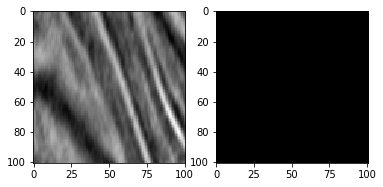

In [3]:
idx = 11
fname = fname_train_images[idx]
img = cv2.imread(fname)

fname = fname_train_masks[idx]
mask = cv2.imread(fname)
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(mask)

img[1, 0, :], mask[1, 0, :]
img.shape

In [4]:
org_size = (1, 101, 101)
upsample_size = (1, 128, 128)

def load_image(path):
    img = cv2.imread(path)
    img = img[:, :, 0:1] # take only 1 channel because every channel has same values
    img = np.transpose(img, (2, 0, 1))
    img = img/255
    
    return img

def upsample_image(img):
    return resize(img, upsample_size)

def downsample_image(img):
    return resize(img, org_size)

class Resizing:
    def __init__(self, left, right, top, bottom):
        
        self.m = nn.ReflectionPad2d((left, right, top, bottom))
        
        # for slicing
        self.top = top
        self.bottom = -bottom if bottom != 0 else None # 0 not work in slice in unpad function
        self.left = left
        self.right = -right if right != 0 else None
        
    def pad(self, imgs):
        return self.m(imgs)
    
    def unpad(self, imgs):
        return imgs[:, :, self.top:self.bottom, self.left:self.right]

    
size_diff = 128 - 101
pad_size_left = size_diff // 2
pad_size_right = size_diff // 2 + size_diff % 2
pad_size_top = pad_size_left
pad_size_bottom = pad_size_right
print(pad_size_left, pad_size_right, pad_size_top, pad_size_bottom)

a = torch.arange(25).reshape(1,1,5,5)
rs = Resizing(0, 1, 0, 2)
b = rs.pad(a)
rs.unpad(b)


13 14 13 14


tensor([[[[  0.,   1.,   2.,   3.,   4.],
          [  5.,   6.,   7.,   8.,   9.],
          [ 10.,  11.,  12.,  13.,  14.],
          [ 15.,  16.,  17.,  18.,  19.],
          [ 20.,  21.,  22.,  23.,  24.]]]])

In [5]:


class SaltDataset(Dataset):
    def __init__(self, root_path, file_ids, is_test=False):
        self.root_path = root_path
        self.file_ids = file_ids
        self.is_test = is_test
    
    def __len__(self):
        return len(self.file_ids)
    
    def __getitem__(self, idx):
        
        file_id = self.file_ids[idx]
        
        if self.is_test:
            image_folder = self.root_path
        else:
            image_folder = os.path.join(self.root_path, "images")
        
        image_path = os.path.join(image_folder, file_id + ".png")
        
        img = load_image(image_path)
        #img = upsample_image(img).astype(np.float32)
        img = img.astype(np.float32)
        
        if self.is_test:
            return img
        
        else:
            mask_folder = os.path.join(self.root_path, "masks")
            mask_path = os.path.join(mask_folder, file_id + ".png")
            mask = load_image(mask_path)
            #mask = upsample_image(mask).astype(np.float32)
            mask = mask.astype(np.float32)

            return img, mask
        
    
    

In [6]:
def train(model, device, data_loader, loss_fn, optimizer):
    train_loss = []
    model.train()
    
    for image, mask in tqdm(data_loader):
        image, mask = image.to(device), mask.to(device)
        
        y_pred = model(image)
        loss = loss_fn(y_pred, mask)
        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
    
    return np.mean(train_loss)


def validation(model, device, data_loader, loss_fn):
    val_loss = []
    model.eval()
    
    with torch.no_grad():
        for image, mask in data_loader:
            image, mask = image.to(device), mask.to(device)
            y_pred = model(image)

            loss = loss_fn(y_pred, mask)
            val_loss.append(loss.item())
    
    return np.mean(val_loss)
            
            

In [12]:
train_ids = train_ids[:16*4]
val_id_list = train_ids[::10] 
train_id_list = [_id for _id in train_ids if _id not in val_id_list]

train_dataset = SaltDataset(train_dir, file_ids=train_id_list)
val_dataset = SaltDataset(train_dir, file_ids=val_id_list)
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)



device = torch.device("cuda" if use_cuda else "cpu")
model = UNet(num_class=1, input_channel=1, depth=5, start_filters=32,
            pad_l=pad_size_left, pad_r=pad_size_right, pad_t=pad_size_top, pad_b=pad_size_bottom
            ).to(device)

learning_rate = 1e-4
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_epoch = 10

train_loss_list = []
val_loss_list = []


100%|██████████| 4/4 [02:07<00:00, 31.84s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0, Train: 0.556, Val: 0.667



100%|██████████| 4/4 [01:34<00:00, 23.72s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1, Train: 0.552, Val: 0.655



100%|██████████| 4/4 [01:34<00:00, 23.57s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 2, Train: 0.547, Val: 0.645



100%|██████████| 4/4 [01:57<00:00, 29.42s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 3, Train: 0.538, Val: 0.636



100%|██████████| 4/4 [02:03<00:00, 30.92s/it]


Epoch: 4, Train: 0.532, Val: 0.630


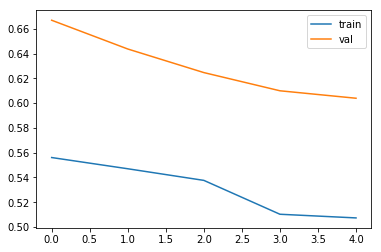

In [13]:
n_epoch = 5
for epoch in range(n_epoch):
    
    train_loss = train(model, device, train_data_loader, loss_fn, optimizer)
    train_loss_list.append(train_loss)
    
    val_loss = validation(model, device, val_data_loader, loss_fn)
    val_loss_list.append(val_loss)
    
    print("Epoch: %d, Train: %.3f, Val: %.3f" % (epoch, np.mean(train_loss_list), np.mean(val_loss_list)))

plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="val")
plt.legend()
        

In [ ]:
#torch.save(model.state_dict(), "model")

### submission

In [14]:
#model.load_state_dict(torch.load("model"))

In [19]:
# https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification
def rlenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [20]:


def test(model, device, data_loader, threshold):
    model.eval()
    
    y_pred_all = []
    
    with torch.no_grad():
        
        for img in tqdm(data_loader):
            img = img.to(device)
            y_pred = model(img)
            img_pred = y_pred[0].cpu().numpy()
            ds_img = downsample_image(img_pred)
            
            ds_img[ds_img >= threshold] = 1
            ds_img[ds_img < threshold] = 0
            
            y_pred_all.append(ds_img[0])
    
    
    y_pred_all = np.array(y_pred_all)
    return y_pred_all
            

In [21]:
threshold = 0.5
test_dataset = SaltDataset(test_image_dir, file_ids=test_ids, is_test=True)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
y_pred_all = test(model, device, test_data_loader, threshold)



/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [22]:
pred_dict = {idx: rlenc(mask) for (idx, mask) in zip(test_ids, y_pred_all)}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.